In [2]:
from LibDB import *
from LibHelper import *
import matplotlib.pyplot as plt
from NiceColours import *
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [10]:
#the following are helper functions:

def errors(DFA, NP, testset, trainset):
    c0 = 0.25 * np.ones((NP,))
    c, _ = DB.OptGeneral(trainset, DFA, c0)
    return DB.GetErrors(testset, DFA(c))

# Computes Mij = (T[i,j] + small) / (T[i,i] + small) 
def m2t(T, small=0.01):
    T = np.array(T)  # Convert T to NumPy array
    T_diag = np.diag(T) + small  # Add small to diagonal elements
    T_diag = T_diag[:, np.newaxis]  # Reshape diagonal array for broadcasting
    
    result = (T + small) / T_diag  
    return result

def plot_matrix(matrix, labels, NP, numb=True, yaxistick = True, colorbar = False, rot = -60):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    font = 10

    # Create custom colormap
    white_to_blue = LinearSegmentedColormap.from_list("white_blue", ["white", "blue"], N=100)
    blue_to_red = LinearSegmentedColormap.from_list("blue_red", ["blue", "red"], N=100)
    combined_colormap = ListedColormap(["white"] + white_to_blue(np.linspace(0, 1, 100)).tolist() + blue_to_red(np.linspace(0, 1, 100)).tolist() + ["red"])

    # Set custom color limits
    cax = ax.matshow(matrix, cmap=combined_colormap, vmin=1, vmax=3)

   # Set ticks and labels for rows and columns
    ax.tick_params(labelbottom=True ,labeltop=False)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    atlabels = ['@' + label for label in labels]
    ax.set_xticklabels(atlabels,  rotation=rot, fontsize=12)
    #ax.set_yticklabels(atlabels, fontsize=12)

    if yaxistick == True:
        ax.set_yticklabels(labels,  fontsize=12)
    else:
        ax.set_yticks([])

    # Set x-axis and y-axis labels with increased font size
      # You can set this to any base value you prefer
    ax.set_xlabel(f"T with {NP} params", fontsize=14)
    ax.xaxis.set_label_position('top')


    # Loop over data dimensions and create text annotations
    if numb == True:
        for i in range(len(labels)):
            for j in range(len(labels)):
                val = matrix[i, j];
                if val < 1.7: fg, bg = 'k', 'w'
                else: fg, bg = 'w', (0.3,0.3,0.3,1.0)
                text = ax.text(j, i, f"{matrix[i, j]:.1f}", ha="center", va="center", color=fg, fontsize = 12,  rotation=-45)

    if colorbar == True:
        fig.colorbar(cax)

    return fig, ax

In [11]:
# This the the database for generating DFAs and results
DB = DFADB()
# This initialises all subsets of GMTKN55 (e.g. "W4-11" "G21EA", etc) and full GMTKN55
DB.Combine("GMTKN55", DB_GMTKN55) # Read all GMTKN55
# This initialises all subsets of TMC151 ('tmd', 'mor', 'tmb') and the full TMC151
DB.Combine("TMC151", DB_TMC151)
#Initialised T100 set
DB.Extract('Transferable100')
DB.Alias('T100', 'Transferable100')

'T100'

In [12]:
#errors(DFA, NP, testset, trainset)
#gives us errors for a 'testset' of a 'DFA' with 'NP' parameters 
ers = errors(XYG_BLYP, 7, "S22", "S22")

In [13]:
#test@train notation
#a DFA [e.g., DFA_XYG_BLYP (BLYP parent) or DFA_XYG_SCAN (r2SCAN parent) or DFA_XYG_PBE (PBE parent)
#with NP parameters (from 1 to 7 for XYGp)

#examples: 
ers = errors(DFA_XYG_BLYP, 7, "S22", "T100")
print(f"S22@T100 (p = 7) MAD(kcal/mol) is {round(np.mean(abs(ers)), 2)}")

#examples: 
ers = errors(DFA_XYG_BLYP, 4, "BH76", "BH76")
print(f"BH76@BH76 (p = 4) MAD(kcal/mol) is {round(np.mean(abs(ers)), 2)}")
ers = errors(DFA_XYG_BLYP, 4, "BH76", "T100")
print(f"BH76@T100 (p = 4) MAD(kcal/mol) is {round(np.mean(abs(ers)), 2)}")

S22@T100 (p = 7) MAD(kcal/mol) is 0.32
BH76@BH76 (p = 4) MAD(kcal/mol) is 2.27
BH76@T100 (p = 4) MAD(kcal/mol) is 3.39


In [14]:
#calculates sets of optimized paramters for training set (e.g, whole "GMTKN55")
#for DFA = DFA_XYG_SCAN (see LibDB.py to check what each parameter respresents)
#with number of parameters NP = 7

DFA = DFA_XYG_SCAN; NP = 7; 
c0 = 0.25 * np.ones((7,))
c, _ = DB.OptGeneral("GMTKN55", DFA_XYG_BLYP, c0);
print('Optimal parameters are', c)

Optimal parameters are [0.80586317 0.09366859 0.08294451 0.2405938  0.17474215 0.64061001
 0.62170604]


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='T with 2 params'>)

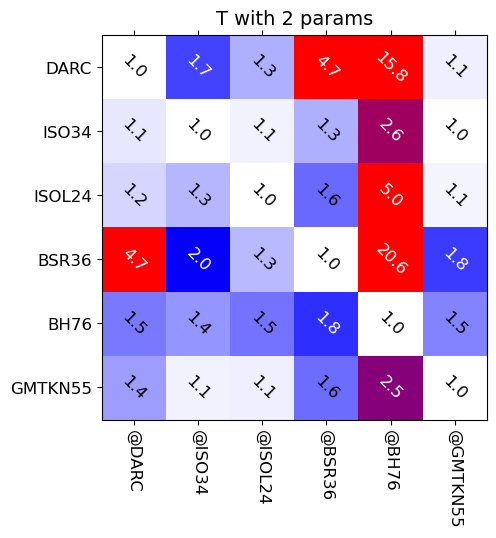

In [15]:
#The following calculates and plots Transferability matrix for 
#a List of Sets: "SetList"
#for "DFA" with "NP" parameters

SetList = ["DARC", "ISO34", "ISOL24",  "BSR36",  "BH76", "GMTKN55"];

DFA = DFA_XYG_BLYP; NP = 2 #choose DFA and number of parameters
c0 = 0.25 * np.ones((NP,))

#store all params
NSet = len(SetList)
c_all = np.zeros((NSet, NP ));
    
#MAD A@B:
Err = np.zeros((NSet, NSet))
for K1, Set1 in enumerate(SetList):
    c, _ = DB.OptGeneral(Set1, DFA, c0)
    c_all[K1] = c; 
    for K2, Set2 in enumerate(SetList):
        Err[K1,K2] = DB.GetMAD(Set2, DFA(c))

#Create Transferability matrix from MAD A@B:

Tmat = m2t(Err.T, small=0.01)

#Plot Transferability matrix:


plot_matrix(Tmat, SetList, NP, numb= True, rot = -90) 